<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Import Libraries

In [1]:
base_path = "../"

In [2]:
import pandas as pd
import zipfile
import pickle
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import regularizers
from classes import *
from functions import *

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import optimizers

In [4]:
#Load the DataFrames from the .pkl files
with open(os.path.join(base_path,"data/train_df.pkl"), "rb") as f:
     train_df = pickle.load(f)

with open(os.path.join(base_path,"data/val_df.pkl"), "rb") as f:
     val_df = pickle.load(f)

with open(os.path.join(base_path,"data/test_df.pkl"), "rb") as f:
     test_df = pickle.load(f)

with open(os.path.join(base_path,"data/train_df_sampled.pkl"), "rb") as f:
     train_df_sampled = pickle.load(f)

with open(os.path.join(base_path,"data/family_encoder.pkl"), "rb") as f:
     family_encoder = pickle.load(f)

In [5]:
class_names = family_encoder.classes_

class_names

array(['accipitridae', 'acipenseridae', 'acroporidae', 'agamidae',
       'agariciidae', 'albulidae', 'alcedinidae', 'alligatoridae',
       'alopiidae', 'ambystomatidae', 'anatidae', 'anguidae', 'aotidae',
       'apidae', 'ardeidae', 'arthroleptidae', 'atelidae', 'attelabidae',
       'balaenicipitidae', 'balaenidae', 'balaenopteridae', 'balistidae',
       'bombycillidae', 'bovidae', 'brachypteraciidae', 'bucerotidae',
       'bufonidae', 'burhinidae', 'cacatuidae', 'callitrichidae',
       'callorhinchidae', 'caprimulgidae', 'carabidae', 'carcharhinidae',
       'cardiidae', 'carettochelyidae', 'cebidae', 'cerambycidae',
       'cercopithecidae', 'cervidae', 'cetorhinidae', 'chaetodontidae',
       'chamaeleonidae', 'charadriidae', 'cheirogaleidae', 'chelidae',
       'cheloniidae', 'chelydridae', 'ciconiidae', 'coenagrionidae',
       'colubridae', 'columbidae', 'conidae', 'cracidae', 'cricetidae',
       'crocodylidae', 'cryptobranchidae', 'ctenomyidae', 'cuculidae',
       'cypr

<div class="alert alert-block alert-success">

# **2.** Preprocessing

<div>

In [6]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

In [7]:
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

2025-04-29 20:50:11.704456: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-29 20:50:11.704485: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-29 20:50:11.704491: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-29 20:50:11.704645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-29 20:50:11.704660: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<div class="alert alert-block alert-success">

# **3.** Results Analysis

<div>

In [8]:
# Load model keras\
model = load_model(os.path.join(base_path,"project/efficient_net_finetuned_final.keras"))

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 34 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
# load datasets with efficientnets preprocessing
train_ds, _ = preprocess.load_img(
    data_dir=os.path.join(base_path,"data/rare_species/train"),
    minority_class=minority_class,
    augment="mixup",
    oversampling=False,
    shuffle= True,
    preprocessing_function=preprocess_input)

val_ds, _ = preprocess.load_img(
    data_dir=os.path.join(base_path,"data/rare_species/val"),
    minority_class=[],
    augment=None,
    shuffle= False,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [10]:
y_pred = model.predict(val_ds)

2025-04-29 20:50:14.643935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step


### Classification report

In [22]:
get_metric(val_ds, os.path.join(base_path,"project/efficient_net_finetuned_final.keras"))


Evaluating model: ../project/efficient_net_finetuned_final.keras


/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 34 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


              precision    recall  f1-score   support

           0     0.7391    0.9444    0.8293        18
           1     0.6429    0.6923    0.6667        13
           2     0.6579    0.8065    0.7246        31
           3     0.7143    0.5556    0.6250         9
           4     0.6364    0.7778    0.7000        18
           5     0.6000    0.6000    0.6000         5
           6     0.0000    0.0000    0.0000         4
           7     0.6667    0.4000    0.5000         5
           8     1.0000    0.1111    0.2000         9
           9     1.0000    0.3333    0.5000         9
          10     0.6364    0.7778    0.7000        27
          11     0.7500    0.6667    0.7059         9
          12     1.0000    0.5556    0.7143         9
          13     1.0000    1.0000    1.0000        22
          14     0.7143    0.5556    0.6250         9
          15     1.0000    0.5000    0.6667         4
          16     0.5909    0.5909    0.5909        22
          17     1.0000    

2025-04-29 18:19:16.274259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brunasimoes/Desktop/nova_ims

(array([  0,   0,   0, ..., 201, 201, 201]),
 array([  0,   0,   0, ..., 201, 201, 201]))

### Incorporate phylum

#### Histogram of model confidence, divided by correctly and incorrectly classified images

In [11]:
# Create a list of all images and labels
train_images = []
train_labels = []

for batch in train_ds:
    images_batch, labels_batch = batch
    train_images.append(images_batch.numpy())
    train_labels.append(labels_batch.numpy())

# Stack properly
train_images = np.vstack(train_images)
train_labels = np.vstack(train_labels)

print(train_images.shape)
print(train_labels.shape)

2025-04-29 20:51:01.599719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(8388, 224, 224, 3)
(8388, 202)


In [12]:
# Predict all train images
pred_probs_all = model.predict(train_ds, verbose=1)
y_pred = np.argmax(pred_probs_all, axis=1)
y_true = train_labels

263/263 ━━━━━━━━━━━━━━━━━━━━ 68s 238ms/step


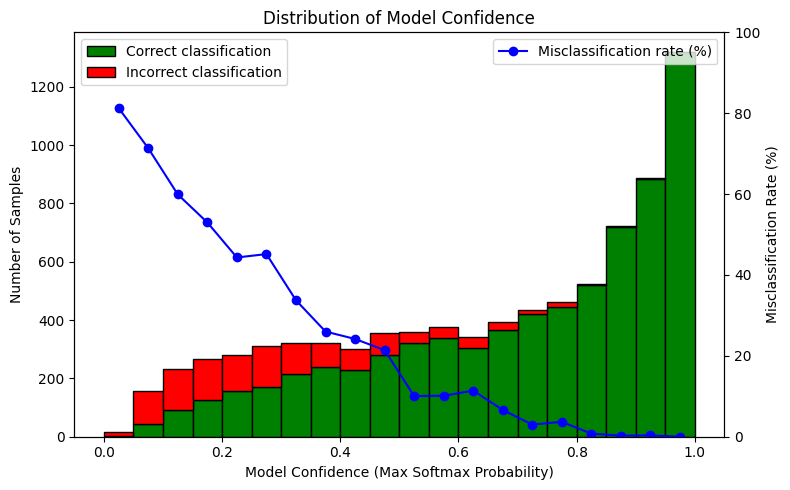

In [13]:
# 1) prepare labels
labels = train_labels
if labels.ndim > 1:
    labels = np.argmax(labels, axis=1)

# 2) get preds and confidences
preds = np.argmax(pred_probs_all, axis=1)
confidences = np.max(pred_probs_all, axis=1)

# 3) split confidences by correctness
correct_conf = confidences[preds == labels]
incorrect_conf = confidences[preds != labels]

# 4) define bins
bins = np.linspace(0, 1, 21)  # 20 bins

# 5) histogram counts for each bin
correct_counts, _   = np.histogram(correct_conf,   bins=bins)
incorrect_counts, _ = np.histogram(incorrect_conf, bins=bins)
total_counts = correct_counts + incorrect_counts

# 6) misclassification rate per bin (in %), guard against zero-division
with np.errstate(divide='ignore', invalid='ignore'):
    misclass_rate = 100 * incorrect_counts / total_counts
misclass_rate = np.nan_to_num(misclass_rate)  # zero where total_counts==0

# 7) bin centers for plotting the line
bin_centers = (bins[:-1] + bins[1:]) / 2

# 8) plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# stacked histogram
ax1.hist(
    [correct_conf, incorrect_conf],
    bins=bins,
    stacked=True,
    color=['green', 'red'],
    label=['Correct classification', 'Incorrect classification'],
    edgecolor="black"
)
ax1.set_xlabel('Model Confidence (Max Softmax Probability)')
ax1.set_ylabel('Number of Samples')
ax1.legend(loc='upper left')

# secondary axis for misclassification %
ax2 = ax1.twinx()
ax2.plot(
    bin_centers,
    misclass_rate,
    marker='o',
    linestyle='-',
    color='blue',
    label='Misclassification rate (%)'
)
ax2.set_ylabel('Misclassification Rate (%)')
ax2.set_ylim(0, 100)
ax2.legend(loc='upper right')

plt.title('Distribution of Model Confidence')
plt.tight_layout()
plt.show()


#### Trying to incorporate phylum

In [14]:
# Unbatch train_ds into list
val_images = []
val_labels = []

for img, label in val_ds.unbatch():
    val_images.append(img.numpy())
    val_labels.append(label.numpy())

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Predict all val images
pred_probs_all_val = model.predict(val_images, verbose=1)
y_pred = np.argmax(pred_probs_all, axis=1)
y_true = val_labels

2025-04-29 20:52:57.344238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# create family:phylum dicionary
meta = pd.read_csv('../data/rare_species/metadata.csv')
dup = meta.groupby('family')['phylum'].nunique()
family_to_phylum = dict(zip(meta['family'], meta['phylum']))


In [16]:
# --- 2) Prepare true labels & names ---
# train_labels: your true labels, shape (11200,) or one-hot (11200,202)
# class_names: list of length 202 mapping index→family string
labels = np.argmax(val_labels, axis=1) # family# prediction, not one-hot-encoded
y_true_fam   = np.array([class_names[i] for i in labels])
y_true_phyl  = np.array([family_to_phylum[f] for f in y_true_fam])


In [17]:
# --- 3) Baseline predictions & phylum check ---
y_pred       = np.argmax(pred_probs_all_val, axis=1)
y_pred_fam   = np.array([class_names[i] for i in y_pred])
y_pred_phyl  = np.array([family_to_phylum[f] for f in y_pred_fam])

In [18]:
# a dictionary phylum:[list of indices of classes that belong to that phylum]
phylum_to_inds = {}
for idx, fam in enumerate(class_names):
    ph = family_to_phylum[fam]
    phylum_to_inds.setdefault(ph, []).append(idx)


In [19]:
# --- 4) Hierarchical override logic ---
y_pred_hier = y_pred.copy()
for i, probs in enumerate(pred_probs_all_val):
    # if predicted phylum ≠ true phylum, force to best within true phylum
    if y_pred_phyl[i] != y_true_phyl[i]:
        valid_idx = phylum_to_inds[y_true_phyl[i]]
        y_pred_hier[i] = valid_idx[np.argmax(probs[valid_idx])]



In [20]:
# --- 5) Overall accuracy comparison ---
acc_base  = accuracy_score(labels, y_pred)
acc_hier  = accuracy_score(labels, y_pred_hier)
print(f"Baseline overall accuracy:     {acc_base:.4f}")
print(f"Hierarchical override accuracy:{acc_hier:.4f}")

Baseline overall accuracy:     0.7006
Hierarchical override accuracy:0.7101


In [21]:
print("Classification report with original predictions:")
print(classification_report(labels,y_pred))
print("Classification report with original predictions:")
print(classification_report(labels,y_pred_hier,digits=4))

Classification report with original predictions:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83        18
           1       0.64      0.69      0.67        13
           2       0.66      0.81      0.72        31
           3       0.71      0.56      0.62         9
           4       0.64      0.78      0.70        18
           5       0.60      0.60      0.60         5
           6       0.00      0.00      0.00         4
           7       0.67      0.40      0.50         5
           8       1.00      0.11      0.20         9
           9       1.00      0.33      0.50         9
          10       0.64      0.78      0.70        27
          11       0.75      0.67      0.71         9
          12       1.00      0.56      0.71         9
          13       1.00      1.00      1.00        22
          14       0.71      0.56      0.62         9
          15       1.00      0.50      0.67         4
          16       0.59      0.5

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWar

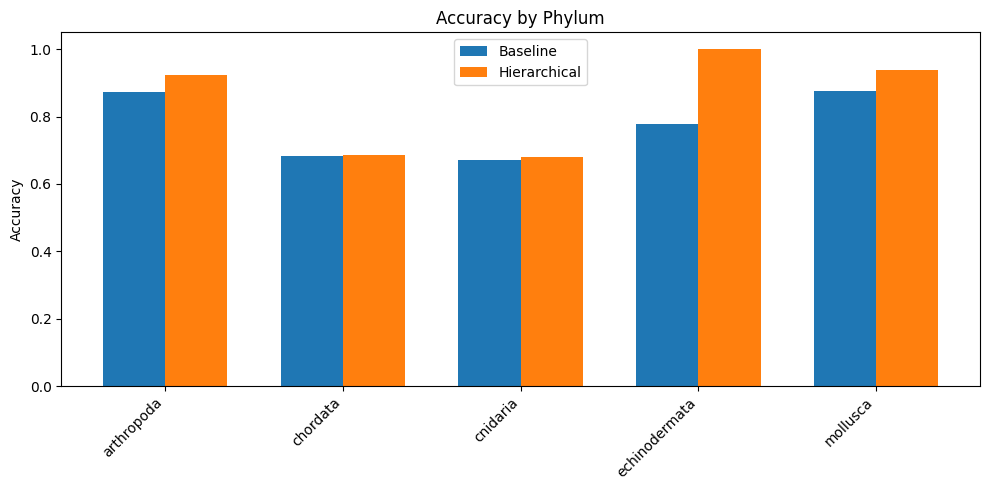

In [22]:
# --- 6) Per-phylum accuracy improvement ---
phyla = np.unique(y_true_phyl)
base_scores = []
hier_scores = []
for ph in phyla:
    idxs = np.where(y_true_phyl == ph)[0]
    base_scores.append( accuracy_score(labels[idxs], y_pred[idxs]) )
    hier_scores.append( accuracy_score(labels[idxs], y_pred_hier[idxs]) )

x = np.arange(len(phyla))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, base_scores, width, label='Baseline')
plt.bar(x + width/2, hier_scores, width, label='Hierarchical')
plt.xticks(x, phyla, rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Accuracy by Phylum')
plt.legend()
plt.tight_layout()
plt.show()
